Social Media Sentiment Analysis

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('twitter_training.csv')  # Replace with your file path
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
# Rename columns using a dictionary
df = df.rename(columns={
    '2401': 'id',
    'Positive': 'Sentiment',
    'im getting on borderlands and i will murder you all ,': 'text'
})

# Verify the new column names
print(df.columns)


Index(['id', 'Borderlands', 'Sentiment', 'text'], dtype='object')


In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean tweets
def clean_text(text):
    if isinstance(text, str):  # Ensure the text is a string
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'\@\w+|\#', '', text)  # Remove @mentions and hashtags
        text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
        text = text.lower()  # Convert to lowercase
        words = text.split()
        words = [word for word in words if word not in stop_words]  # Remove stopwords
        return ' '.join(words)
    else:
        return ''  # Return empty string if text is not valid (e.g., NaN or float)

# Optionally: Fill NaN values with empty strings
df['text'] = df['text'].fillna('')

# Apply cleaning to the 'text' column (replace 'text' with the column containing tweets/posts)
df['cleaned_text'] = df['text'].apply(clean_text)

# Show the cleaned data
df.head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ANSH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,Borderlands,Sentiment,text,cleaned_text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder


In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']  # Compound score gives overall sentiment

# Apply the sentiment analysis
df['sentiment_score'] = df['cleaned_text'].apply(get_sentiment)

# Classify sentiment based on the compound score
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

df.head()


,id,Borderlands,Sentiment,text,cleaned_text,sentiment_score,sentiment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,-0.6908,negative
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,-0.6908,negative
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,-0.6908,negative
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder,-0.6908,negative
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,-0.6908,negative


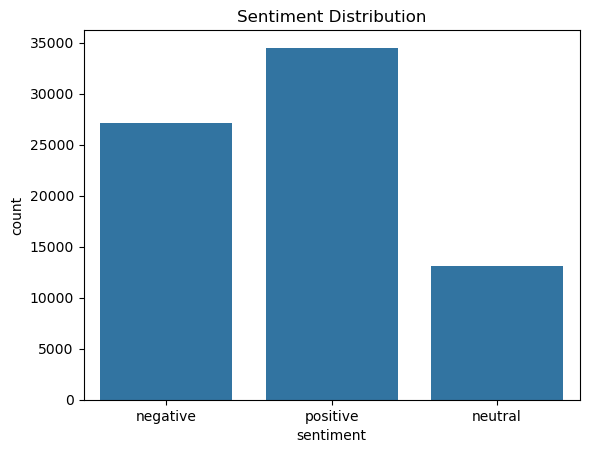

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()


In [12]:
# Assuming your DataFrame has a 'sentiment' column with values like 'positive', 'negative', 'neutral'

# 1. Count the number of occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# 2. Calculate the percentage for each sentiment
sentiment_percentage = (sentiment_counts / len(df)) * 100

# 3. Display the results
print(sentiment_percentage)


sentiment
positive    46.189794
negative    36.294372
neutral     17.515834
Name: count, dtype: float64


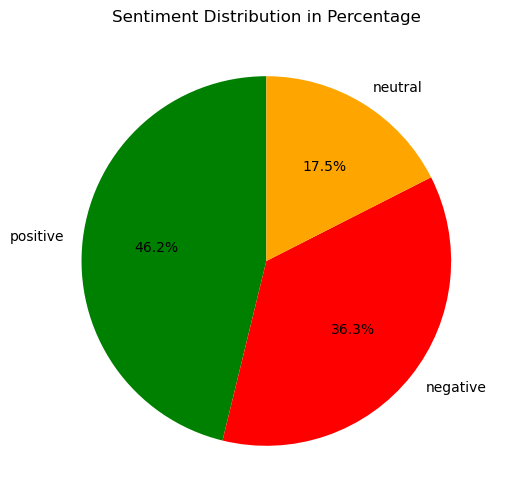

In [13]:
import matplotlib.pyplot as plt

# Plot a pie chart for sentiment percentages
plt.figure(figsize=(6, 6))
plt.pie(sentiment_percentage, labels=sentiment_percentage.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red', 'orange'])
plt.title('Sentiment Distribution in Percentage')
plt.show()


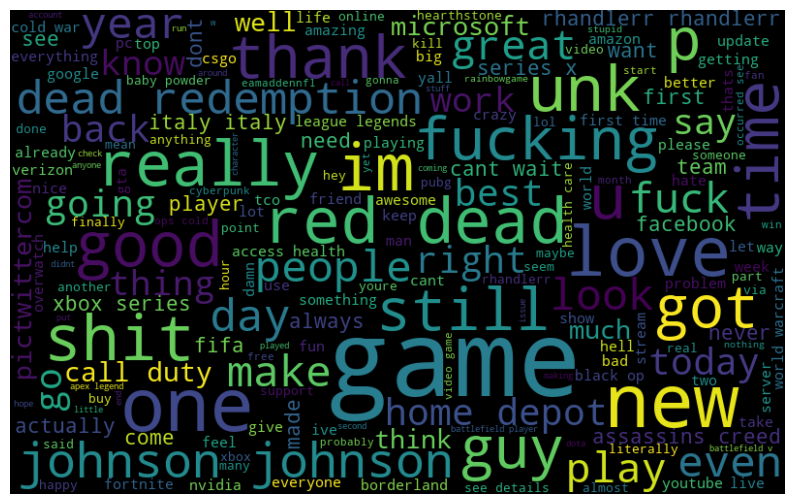

In [14]:
from wordcloud import WordCloud

# Combine all cleaned text into one string
all_words = ' '.join([text for text in df['cleaned_text']])

# Generate word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [15]:
# Find the sentiment with the highest count
most_common_sentiment = df['sentiment'].value_counts().idxmax()

# Filter the dataset to include only rows with the most common sentiment
filtered_df = df[df['sentiment'] == most_common_sentiment]


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer to find important words (topics)
tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words='english')  # You can adjust 'max_features' for more/less words

# Fit and transform the cleaned text from the filtered dataset
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['cleaned_text'])

# Get the top words (features) and their scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Sum of scores for each word across all posts

# Create a DataFrame to sort and display the top words by score
top_words_df = pd.DataFrame({'word': feature_names, 'score': tfidf_scores})
top_words_df = top_words_df.sort_values(by='score', ascending=False)

# Display the top 10 words (topics)
print(top_words_df.head(10))


      word        score
5     game  2395.864592
11    love  2189.115510
7     good  2166.837752
10    like  2121.655818
2     best  1818.561584
9       im  1691.483819
8    great  1572.364043
14    play  1469.407578
16  really  1292.716938
12     new  1278.502693


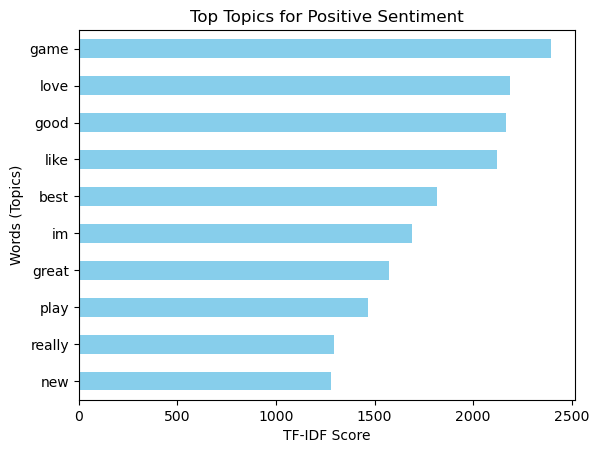

In [17]:
# Plot a bar chart of the top words (topics) for the most frequent sentiment
import matplotlib.pyplot as plt

top_words_df.head(10).plot(kind='barh', x='word', y='score', legend=False, color='skyblue')
plt.title(f"Top Topics for {most_common_sentiment.capitalize()} Sentiment")
plt.xlabel('TF-IDF Score')
plt.ylabel('Words (Topics)')
plt.gca().invert_yaxis()  # To display the largest score at the top
plt.show()
